# Analytics Capstone

Anton Aro

### Introduction

- This project aims to help a restauranteur to understand the geography of Helsinki to identify strategic location options for a new restaurant to attract locals to enjoy lunch or dinner
- The project will analyse Espoo area and provide recommendations based on findings

Helsinki is a diverse waterfront city with active culinary scene offering a wide variety of dining options, but most of them are in the centrally located areas. The opportunities outside central most Helsinki should be identified as locals the aim would be to make dining out more convenient and easy. For many inhabitants the centrally located restaurants require some transportation and if they had an option of neighborhood bistro, that would potentially be greatly appreciated as has been found in neighborhood city of Espoo.

### Data

The project will use following data sources:

- Foursquare API to retrieve information about current dining options in Espoo (based on category, location, style etc.). The packages to run this API query are not installed at this stage.
- Demographic data is retrieved from StatFi Helsinki related dataset extracted from StatFi portal on postal code level
- Geographics locations and boundaries are for Helsinki postal codes are retrieved in .KML-file from Capitol Area opean data portal


In [25]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library
import matplotlib.pyplot as plt

!pip install pykml
!pip install git+git://github.com/geopandas/geopandas.git
!pip install fiona
!pip install pyproj

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

### Espoo data

Data import from .csv file retrieved from Statistic Finland open data portal

- Demographics
- Geographic

In [2]:
# The code was removed by Watson Studio for sharing.

,Community,X coordinate in metres,Y coordinate in metres,Surface area,"Inhabitants, total, 2019 (HE)","Males, 2019 (HE)","Females, 2019 (HE)","Average age of inhabitants, 2019 (HE)","0-2 years, 2019 (HE)","3-6 years, 2019 (HE)",...,"U Activities of extraterritorial organisations and bodies, 2018 (TP)","X Industry unknown, 2018 (TP)","Inhabitants, 2018 (PT)","Employed, 2018 (PT)","Unemployed, 2018 (PT)","Children aged 0 to 14, 2018 (PT)","Students, 2018 (PT)","Pensioners, 2018 (PT)","Others, 2018 (PT)",Name
0,02100 Tapiola (Espoo),378056,6673140,1907447,5344,2567,2777,45,143,154,...,0,0,5193,2491,146,568,317,1515,156,02100
1,02110 Otsolahti (Espoo),379011,6673189,878222,2823,1401,1422,41,94,122,...,0,0,2779,1438,72,402,186,567,114,02110
2,02120 Länsikorkee-Suvikumpu (Espoo),377402,6672830,712858,2863,1405,1458,42,105,118,...,0,0,2768,1388,85,397,184,622,92,02120
3,02130 Pohjois-Tapiola (Espoo),378010,6674565,2646566,6399,3147,3252,40,168,364,...,0,0,6354,3007,163,1292,446,1255,191,02130
4,02140 Laajalahti (Espoo),378092,6675820,2429132,3651,1852,1799,38,116,206,...,0,0,3708,1718,132,851,283,579,145,02140


### Retrieve open location data from open data portal

In [7]:

from pykml import parser
import urllib.request as urllib2
import geopandas as gpd
import fiona
from shapely.wkt import loads as load_wkt

# Import postcode areas from KML file
kml_url_hel_postcode = "https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/9_Kartat/PKS%20postinumeroalueet/Kml/Pks_postinumeroalueet_2020.kml"

fileobject = urllib2.urlopen(kml_url_hel_postcode)

root = parser.parse(fileobject).getroot()
print(root.Document.Folder)

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df_post_code_1 = gpd.read_file(kml_url_hel_postcode, driver='KML')

df_post_code_1['PostCode'] = df_post_code_1['Name']

# Only use Espoo data, where postal code starts with 02
df_post_code_2 = df_post_code_1[df_post_code_1['Name'].str.startswith("02")]

# Merge geographics and demographic data to primary DF
df_post_code_3 = df_post_code_2.merge(data, how='inner', on='Name')

# Define central point for each post code area
df_post_code_3['Centroid'] = df_post_code_3['geometry'].centroid
df_post_code_3['Centroid_Lon'] = df_post_code_3['Centroid'].x
df_post_code_3['Centroid_Lat'] = df_post_code_3['Centroid'].y


# Test central points for first row
lat_1 = df_post_code_3.iloc[0, 113]
lon_1 = df_post_code_3.iloc[0, 112]
#print(lat_1)

#df_post_code_3['Coords'] = list((df_post_code_3['Centroid_Lat'], df_post_code_3['Centroid_Lon']))
df_post_code_3.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,Name,Description,geometry,PostCode,Community,X coordinate in metres,Y coordinate in metres,Surface area,"Inhabitants, total, 2019 (HE)","Males, 2019 (HE)",...,"Inhabitants, 2018 (PT)","Employed, 2018 (PT)","Unemployed, 2018 (PT)","Children aged 0 to 14, 2018 (PT)","Students, 2018 (PT)","Pensioners, 2018 (PT)","Others, 2018 (PT)",Centroid,Centroid_Lon,Centroid_Lat
0,02100,02100<center><table><tr><th colspan='2' align=...,"POLYGON Z ((24.83567 60.13042 0.00000, 24.8309...",02100,02100 Tapiola (Espoo),378056,6673140,1907447,5344,2567,...,5193,2491,146,568,317,1515,156,POINT (24.82117 60.16113),24.821165,60.161125
1,02110,02110<center><table><tr><th colspan='2' align=...,"POLYGON Z ((24.81125 60.18603 0.00000, 24.8111...",02110,02110 Otsolahti (Espoo),379011,6673189,878222,2823,1401,...,2779,1438,72,402,186,567,114,POINT (24.81845 60.17733),24.818451,60.177328
2,02120,02120<center><table><tr><th colspan='2' align=...,"POLYGON Z ((24.79758 60.17602 0.00000, 24.7973...",02120,02120 Länsikorkee-Suvikumpu (Espoo),377402,6672830,712858,2863,1405,...,2768,1388,85,397,184,622,92,POINT (24.79003 60.17335),24.790025,60.173353
3,02130,02130<center><table><tr><th colspan='2' align=...,"POLYGON Z ((24.78834 60.18115 0.00000, 24.7887...",02130,02130 Pohjois-Tapiola (Espoo),378010,6674565,2646566,6399,3147,...,6354,3007,163,1292,446,1255,191,POINT (24.79469 60.18806),24.794693,60.188065
4,02140,02140<center><table><tr><th colspan='2' align=...,"POLYGON Z ((24.79577 60.19624 0.00000, 24.7961...",02140,02140 Laajalahti (Espoo),378092,6675820,2429132,3651,1852,...,3708,1718,132,851,283,579,145,POINT (24.80278 60.20248),24.802784,60.202478


### Define target group based on demographics

- The target group is postcode areas with above average purchasing power

In [8]:

espoo = df_post_code_3.iloc[:, 8:108]
espoo['Name'] = df_post_code_3['Name']
espoo['Target Population Size'] = espoo.iloc[:, 9:14].sum(axis = 1)
espoo['Target Population Proportion'] = espoo['Target Population Size'] / espoo['Inhabitants, total, 2019 (HE)']

espoo_descriptives = pd.DataFrame(espoo.describe())

#Choose target postcodes

espoo_target = espoo.loc[espoo['Accumulated purchasing power of inhabitants, 2019 (HR)'] > espoo_descriptives.iloc[1, 37]]

espoo_df = df_post_code_3.merge(espoo_target, how='inner', on='Name')
espoo_target.shape


(21, 103)

### Foursquare API

- Retrieve restaurants in Espoo for every postcode

In [9]:
# Foursquare API credentials

CLIENT_ID = 'G0KJZSRX3NTV4X5EWCOQMD5L2NTMANCA2YTEZRQEXMS0OAKV' # your Foursquare ID
CLIENT_SECRET = '0ODBZLIP4EG30BIXUYEZR3VQHWHG31WSDSXKTJUZPHC32JDT' # your Foursquare Secret
ACCESS_TOKEN = '0WVTQSC4FJQJ3NOKE23WU51K3GOIHIID0VDJFP2STMG14AFZ' # your FourSquare Access Token HXP2KSGDGKNOR4NCTMOKZTAKOLCGG3ARHJPOWNEWKOAPU0SW#_=_
VERSION = '20212604'
LIMIT = 50
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: G0KJZSRX3NTV4X5EWCOQMD5L2NTMANCA2YTEZRQEXMS0OAKV
CLIENT_SECRET:0ODBZLIP4EG30BIXUYEZR3VQHWHG31WSDSXKTJUZPHC32JDT


In [35]:

postcode_df = pd.DataFrame()
postcode_df['PostCode'] = df_post_code_3['Name']
postcode_df['Latitude'] = df_post_code_3['Centroid_Lat']
postcode_df['Longitude'] = df_post_code_3['Centroid_Lon']
postcode_df['Coords'] = postcode_df.iloc[:, 1:3].values.tolist()

restaurant_df = pd.DataFrame(columns = ['id', 'name', 'categories', 'referralId', 'hasPerk', 'location.lat',
       'location.lng', 'location.labeledLatLngs', 'location.distance',
       'location.postalCode', 'location.cc', 'location.city', 'location.state',
       'location.country', 'location.formattedAddress', 'location.address',
       'location.crossStreet', 'location.neighborhood'])

postcode_df.head()

,PostCode,Latitude,Longitude,Coords
0,02100,60.161125,24.821165,"[60.16112523875311, 24.821165224350214]"
1,02110,60.177328,24.818451,"[60.17732815062949, 24.818451258545554]"
2,02120,60.173353,24.790025,"[60.17335329133658, 24.790025130378307]"
3,02130,60.188065,24.794693,"[60.18806496279541, 24.794692977235755]"
4,02140,60.202478,24.802784,"[60.202478367234484, 24.80278415159779]"


In [11]:
# Retrieve restaurants for all post codes
category_id = '4d4b7105d754a06374d81259'
radius = 2000 # in meters

for ind in postcode_df.index:
    latitude1 = df_post_code_3['Centroid_Lat'][ind]
    longitude1 = df_post_code_3['Centroid_Lon'][ind]
    url1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1,ACCESS_TOKEN, VERSION, category_id, radius, LIMIT)
    #print('Category ID used: ' + category_id)
    results1 = requests.get(url1).json()
    # assign relevant part of JSON to venues
    venues1 = results1['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues1)
    restaurant_df = restaurant_df.append(dataframe, ignore_index=True).drop_duplicates(subset=['id'])



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


# Analysis of areas

Descriptive analysis
- Descriptive statistics on target areas

Correlation analysis
- To check which of the demographic variables correlate most strongly with the number of restaurants in the area
- Area benchmark creation based on average target area and strongest correlation

Cosine similarity analysis
- Cosine similarity as used in content based recommendation systems was used to check the similarity between the target areas


In [12]:
restaurant_aggregate = restaurant_df.copy()

nbr_of_restaurants_1 = pd.DataFrame(restaurant_aggregate['location.postalCode'].value_counts().reset_index())
nbr_of_restaurants = nbr_of_restaurants_1.rename(columns={"index": "Name", "location.postalCode": "Restaurants"})
nbr_of_restaurants
espoo_restaurants = espoo_target.merge(nbr_of_restaurants, how='inner', on='Name')

# Retrieve benchmark average values for chosen restaurant areas
espoo_top_restaurant_areas = espoo_restaurants.sort_values(by = 'Restaurants', ascending = False).head(5)
espoo_top_restaurant_area_mean = pd.DataFrame(espoo_top_restaurant_areas.describe().iloc[1, :]).transpose()

espoo_top_restaurant_areas.describe()

,"Inhabitants, total, 2019 (HE)","Males, 2019 (HE)","Females, 2019 (HE)","Average age of inhabitants, 2019 (HE)","0-2 years, 2019 (HE)","3-6 years, 2019 (HE)","7-12 years, 2019 (HE)","13-15 years, 2019 (HE)","16-17 years, 2019 (HE)","18-19 years, 2019 (HE)",...,"Q Human health and social work activities, 2018 (TP)","R Arts, entertainment and recreation, 2018 (TP)","S Other service activities, 2018 (TP)","T Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use, 2018 (TP)","U Activities of extraterritorial organisations and bodies, 2018 (TP)","X Industry unknown, 2018 (TP)","Inhabitants, 2018 (PT)",Target Population Size,Target Population Proportion,Restaurants
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000
mean,13591.600000,6627.200000,6964.400000,40.200000,435.200000,604.000000,835.400000,402.000000,255.000000,272.200000,...,890.400000,217.400000,209.800000,0.0,0.0,0.0,13211.800000,4722.600000,0.348261,31.200000
std,6207.164353,2974.003648,3239.018725,3.701351,203.810451,301.477196,411.842567,216.249855,129.976921,126.264405,...,271.756877,113.354753,86.357976,0.0,0.0,0.0,6251.808594,2276.456742,0.063230,7.014271
min,5344.000000,2567.000000,2777.000000,36.000000,143.000000,154.000000,239.000000,113.000000,62.000000,73.000000,...,635.000000,120.000000,133.000000,0.0,0.0,0.0,5193.000000,1789.000000,0.271045,22.000000
25%,10921.000000,5480.000000,5441.000000,38.000000,379.000000,529.000000,732.000000,335.000000,234.000000,246.000000,...,781.000000,161.000000,136.000000,0.0,0.0,0.0,10706.000000,3644.000000,0.333669,27.000000
50%,13191.000000,6577.000000,6614.000000,39.000000,460.000000,648.000000,828.000000,345.000000,241.000000,299.000000,...,827.000000,177.000000,182.000000,0.0,0.0,0.0,11898.000000,4482.000000,0.334768,31.000000
75%,16536.000000,7886.000000,8650.000000,43.000000,486.000000,707.000000,1013.000000,536.000000,326.000000,333.000000,...,857.000000,219.000000,269.000000,0.0,0.0,0.0,16489.000000,5885.000000,0.355686,37.000000
max,21966.000000,10626.000000,11340.000000,45.000000,708.000000,982.000000,1365.000000,681.000000,412.000000,410.000000,...,1352.000000,410.000000,329.000000,0.0,0.0,0.0,21773.000000,7813.000000,0.446138,39.000000


### Correlation of demograpic variables to the number of restaurants in the area

- Check which variables have highgest correlation to the number of restaurants in the area
- Use correlation coefficient threshold 0f 0.65

In [14]:
espoo_corr = pd.DataFrame(espoo_restaurants.corr())
restaurant_corr = espoo_corr.loc[espoo_corr['Restaurants'] > 0.65]


### Create benchmark to check area demographic similarity

- Benchmark data using highehst correlating variables is created

In [15]:
espoo_benchmark = espoo_top_restaurant_area_mean[restaurant_corr.index]
espoo_analysis = espoo_restaurants[restaurant_corr.index]
espoo_benchmark

,"20-24 years, 2019 (HE)","25-29 years, 2019 (HE)","Matriculation examination, 2019 (KO)","One-person households, 2019 (TE)","Young single persons, 2019 (TE)","Young couples without children, 2019 (TE)","Adult households, 2019 (TE)","Households living in rented dwellings, 2019 (TE)","Dwellings in blocks of flats, 2019 (RA)","Workplaces, 2018 (TP)","Services, 2018 (TP)","I Accommodation and food service activities, 2018 (TP)","L Real estate activities, 2018 (TP)","Q Human health and social work activities, 2018 (TP)","R Arts, entertainment and recreation, 2018 (TP)","S Other service activities, 2018 (TP)",Target Population Size,Restaurants
mean,906.6,1275.6,1153.4,3162.8,971.2,487.0,3715.8,3760.2,6024.4,6743.6,5947.6,306.6,90.8,890.4,217.4,209.8,4722.6,31.2


### Check area similarity accounting for target population and benchmark

- This section utilizes content based recommender system algorithm based on cosine similarity to compare the areas
- Each area has been prequalified based on target group
- The results indicate how similar the areas are to the benchmark and how saturated the restaurant offerin is there

The recommended areas have the least restaurants and highest similarity to the benchmark area

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
benchmark_df = espoo_benchmark.copy()
similarity_df = espoo_analysis.copy()

cosine_df = espoo_restaurants[['Name', 'Restaurants']]
cosine = pd.DataFrame()

#x_ab = similarity_df.iloc[0,4:106]
for i in similarity_df.index:
    x_sim = np.array(espoo_benchmark.iloc[0,0:16]).reshape(1, -1)
    y_sim = np.array(similarity_df.iloc[i,0:16]).reshape(1, -1)
    cosine_value = pd.DataFrame(cosine_similarity(x_sim, y_sim))
    cosine = cosine.append(cosine_value)


cosine_1 = cosine.rename(columns={0: "Similarity"}) #.reset_index(inplace = True)
cosine_2 = cosine_1.reset_index()
cosine_3 = cosine_2.drop(['index'], axis = 1)
cosine_array = np.array(cosine_3)
cosine_df['Similarity'] = cosine_array
cosine_df['Similarity / Restaurants ratio'] = cosine_df['Similarity'] / cosine_df['Restaurants']



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Recommendations

- Recommendations are based on target areas, their respective similarity an customer potential
- Customer potential is here defined as the target customers per restaurants: the higher the amount the more less served the area is currently meaning that there could be good potential to establish new restaurant busimness

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


New restaurant recommendation post codes

     Name  Target customers per restaurant
18  02750                      1975.000000
19  02760                      1200.250000
12  02620                      1073.000000
22  02940                       890.666667
9   02330                       615.600000


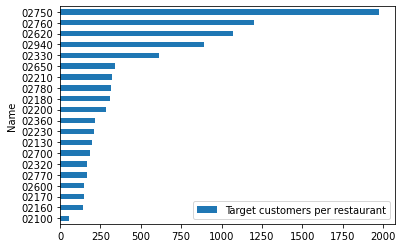

In [27]:
espoo_recommendation_df_1 = espoo_restaurants.merge(cosine_df, how='inner', on='Name')
espoo_recommendation_df = espoo_recommendation_df_1.drop_duplicates(subset=['Name'])


espoo_recommendation_df['Target customers per restaurant'] = espoo_recommendation_df['Target Population Size'] / espoo_recommendation_df['Restaurants_x'] 
espoo_recommendation_df.sort_values(by = 'Target customers per restaurant')

#final_df = pd.DataFrame()
final_df_prep = espoo_recommendation_df[['Name', 'Target customers per restaurant']]
final_df = final_df_prep.merge(df_post_code_3, how='inner', on='Name')
final_df

ax = final_df_prep.sort_values(by = 'Target customers per restaurant').plot.barh(x='Name', y='Target customers per restaurant', rot=0)
print("New restaurant recommendation post codes")
print("")
print(final_df_prep.sort_values(by = 'Target customers per restaurant', ascending = False).head())
#final_df_prep.sort_values(by = 'Target customers per restaurant', ascending = False).head()



### Scatter plot of target customers per restaurant vs. number of restaurants at the postcode area

- The low x and high y value indicate opportunities as there are more prospective customers to be served

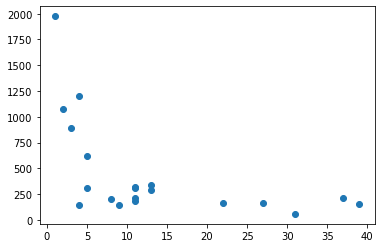

In [64]:
x = espoo_recommendation_df['Restaurants_x']
y = espoo_recommendation_df['Target customers per restaurant']

plt.scatter(x, y)

plt.show()

### Map representation of the centroids for recommended areas

In [58]:
address = 'Espoo' 
# Retrieve coordinates
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)


espoo_map_test = folium.Map(location = [latitude, longitude], zoom_start = 8)

folium.Marker(
    location=list(postcode_df['Coords'].loc[postcode_df['PostCode'] == '02750'])[0], icon=folium.Icon(color='red')).add_to(espoo_map_test)

folium.Marker(
    location=list(postcode_df['Coords'].loc[postcode_df['PostCode'] == '02760'])[0], icon=folium.Icon(color='red')).add_to(espoo_map_test)

folium.Marker(
    location=list(postcode_df['Coords'].loc[postcode_df['PostCode'] == '02620'])[0], icon=folium.Icon(color='red')).add_to(espoo_map_test)

folium.Marker(
    location=list(postcode_df['Coords'].loc[postcode_df['PostCode'] == '02940'])[0], icon=folium.Icon(color='red')).add_to(espoo_map_test)

folium.Marker(
    location=list(postcode_df['Coords'].loc[postcode_df['PostCode'] == '02330'])[0], icon=folium.Icon(color='red')).add_to(espoo_map_test)

espoo_map_test



60.2241869 24.6603626
